In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import time
import re
import scipy
from datetime import time, timedelta
import seaborn as sns
pd.set_option('display.max_columns', 100)

def trans_id(df):
    for i in ['subject_id','hadm_id','stay_id']:
        if i in df.columns.tolist():
            if df[i].dtype == object:
                if ((df[i]== 'None')|(df[i]== 'Null')).any():
                    df[i].replace('None',np.nan,inplace = True)
                    df[i].replace('Null',np.nan,inplace = True)
                    df[i] = df[i].astype(float)
                else:
                    df[i] = df[i].astype(float)

def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return np.datetime64(t)

def trans_float(df):
    for i in df.columns:
        if df[i].dtype == object:
            if ((df[i]== 'None')|(df[i]== 'Null')).any():
                df[i].replace('None',np.nan,inplace = True)
                df[i].replace('Null',np.nan,inplace = True)
                df[i] = df[i].astype(float)
            else:
                df[i] = df[i].astype(float)

In [2]:
def trans_float(df):
    for i in df.columns:
        if df[i].dtype == object:
            if ((df[i]== 'None')|(df[i]== 'Null')).any():
                df[i].replace('None',np.nan,inplace = True)
                df[i].replace('Null',np.nan,inplace = True)
                df[i] = df[i].astype(float)
            else:
                df[i] = df[i].astype(float)

# 读取micro cohort

In [3]:
cohort_WITHMDR = pd.read_csv('cohort_WITHMDR.csv')

for i in ['admittime','dischtime','icu_intime','icu_outtime','charttime','storetime']:
    cohort_WITHMDR[i] = cohort_WITHMDR[i].apply(trans_time)

trans_id(cohort_WITHMDR)

last_intime = cohort_WITHMDR[cohort_WITHMDR['last']==1][['subject_id','icu_intime']].drop_duplicates().\
rename(columns = {'icu_intime':'last_intime'})
cohort_WITHMDR = pd.merge(cohort_WITHMDR,last_intime,how = 'left', on =['subject_id'])

/tmp/ipykernel_1667906/396228243.py:1: DtypeWarning: Columns (10,13,16,18,22,23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  cohort_WITHMDR = pd.read_csv('cohort_WITHMDR.csv')


In [4]:
cohort_WITHMDR.stay_id.drop_duplicates()

0          39553978.0
16         39765666.0
30         37067082.0
31         34592300.0
50         31205490.0
              ...    
1790353    32336619.0
1790357    31070865.0
1790367    36075953.0
1790380    38978960.0
1790389    36195440.0
Name: stay_id, Length: 70153, dtype: float64

# 检出时间

In [5]:
#检出MDR的时间在第一天住ICU之前(本次住院期间)
cohort_all_mdrpos_beforeicu1stday =  cohort_WITHMDR[(cohort_WITHMDR['MDR'] == 1)&\
                                                 (cohort_WITHMDR['org_pos'] == 1)&\
                    (((cohort_WITHMDR['storetime']-cohort_WITHMDR['icu_intime']).dt.total_seconds()/3600)<=24)]

cohort_all_mdrneg_beforeicu1stday =  cohort_WITHMDR[(cohort_WITHMDR['MDR'] == 1)&\
                                                 (cohort_WITHMDR['org_neg'] == 1)&\
                    (((cohort_WITHMDR['storetime']-cohort_WITHMDR['icu_intime']).dt.total_seconds()/3600)<=24)]

In [6]:
#在住ICU第一个24小时前最近一次检出MDRO
cohort_all_lastmdrpos_beforeicu1stday = cohort_all_mdrpos_beforeicu1stday.drop_duplicates().groupby(['stay_id']).\
apply(lambda x: x.sort_values(['storetime'],ascending = False).head(1)).reset_index(drop = True)

cohort_all_lastmdrneg_beforeicu1stday = cohort_all_mdrneg_beforeicu1stday.drop_duplicates().groupby(['stay_id']).\
apply(lambda x: x.sort_values(['storetime'],ascending = False).head(1)).reset_index(drop = True)

#最近一次检出MDRO的信息，以及是否在-30至1天内
cohort_all_lastmdrpos_beforeicu1stday = cohort_all_lastmdrpos_beforeicu1stday[['stay_id',\
                                                           'charttime','storetime','org_name','resistant_ab_cat']].\
rename(columns = {'charttime':'lastbeforeicu1stday_mdrposcharttime',\
                  'storetime':'lastbeforeicu1stday_mdrposstoretime',\
                  'org_name':'lastbeforeicu1stday_mdrposorgname',\
                 'resistant_ab_cat':'lastbeforeicu1stday_mdrposRAB'})

cohort_all_lastmdrneg_beforeicu1stday = cohort_all_lastmdrneg_beforeicu1stday[['stay_id',\
                                                           'charttime','storetime','org_name','resistant_ab_cat']].\
rename(columns = {'charttime':'lastbeforeicu1stday_mdrnegcharttime',\
                  'storetime':'lastbeforeicu1stday_mdrnegstoretime',\
                  'org_name':'lastbeforeicu1stday_mdrnegorgname',\
                 'resistant_ab_cat':'lastbeforeicu1stday_mdrnegRAB'})

# 阳性阴性分类

In [7]:
#positive
cohort_WITHMDR_withlastall = pd.merge(cohort_WITHMDR, cohort_all_lastmdrpos_beforeicu1stday,how = 'left', on = ['stay_id'])

cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoreday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoretime'] - \
                                                                   cohort_WITHMDR_withlastall['icu_intime']).\
dt.total_seconds()/(3600*24)
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposchartday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposcharttime'] - \
                                                                   cohort_WITHMDR_withlastall['icu_intime']).\
dt.total_seconds()/(3600*24)

#negative
cohort_WITHMDR_withlastall = pd.merge(cohort_WITHMDR_withlastall, cohort_all_lastmdrneg_beforeicu1stday,how = 'left', on = ['stay_id'])

cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoreday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoretime'] - \
                                                                   cohort_WITHMDR_withlastall['icu_intime']).\
dt.total_seconds()/(3600*24)
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegchartday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegcharttime'] - \
                                                                   cohort_WITHMDR_withlastall['icu_intime']).\
dt.total_seconds()/(3600*24)

In [8]:
#cohort_WITHMDR_withlastall[cohort_WITHMDR_withlastall['subject_id'] == 10004401].to_csv('test.csv')

cohort_WITHMDR_withlastall['previous_mdrpos_lessthan14d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoreday'].apply(lambda x: 1 if -14<=x<=1 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['previous_mdrneg_lessthan14d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoreday'].apply(lambda x: 1 if -14<=x<=1 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['previous_mdrpos_lessthan90d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoreday'].apply(lambda x: 1 if -90<=x<-14 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['previous_mdrneg_lessthan90d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoreday'].apply(lambda x: 1 if -90<=x<-14 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['micro_specimen_id'] = cohort_WITHMDR_withlastall['micro_specimen_id'].astype(float)

spec_type = cohort_WITHMDR_withlastall[['subject_id','micro_specimen_id','org_name','spec_type_desc']]

spec_type_dum = pd.get_dummies(spec_type, columns = ['spec_type_desc'])

spec_type_SEL = spec_type_dum[[\
               'spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE',\
               'spec_type_desc_SWAB','spec_type_desc_SPUTUM','spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']]

cohort_WITHMDR_withlastall = pd.concat([cohort_WITHMDR_withlastall, spec_type_SEL], axis = 1)

# 标签

In [9]:
#微生物检查及出结果时间与住ICU时间之差
cohort_WITHMDR_withlastall['chart_inttime']=(cohort_WITHMDR_withlastall['charttime']-cohort_WITHMDR_withlastall['icu_intime']).\
dt.total_seconds()/3600
cohort_WITHMDR_withlastall['store_inttime']=(cohort_WITHMDR_withlastall['storetime']-cohort_WITHMDR_withlastall['icu_intime']).\
dt.total_seconds()/3600

cohort_WITHMDR_withlastall['chart_included'] = cohort_WITHMDR_withlastall['chart_inttime'].\
apply(lambda x: 1 if -24<=x<=24 else 0)

cohort_WITHMDR_withlastall[cohort_WITHMDR_withlastall['chart_included']==1].stay_id.drop_duplicates().count()

cohort_WITHMDR_withlastall['chart_included_mdr'] = cohort_WITHMDR_withlastall[['chart_included','MDR']].\
apply(lambda x:1 if (x[0]==1)&(x[1]==1) else 0, axis = 1)

cohort_WITHMDR_withlastall[cohort_WITHMDR_withlastall['chart_included_mdr']==1].stay_id.drop_duplicates()

519        34577403.0
807        38292466.0
920        32743332.0
1027       39801884.0
1117       39699336.0
              ...    
1787556    32930749.0
1787779    32606660.0
1788392    33339952.0
1789176    39143653.0
1790365    31070865.0
Name: stay_id, Length: 4660, dtype: float64

In [10]:
def sel_stay_chart_included(df):
    df_0 = df
    if (df_0['chart_included'] == 1).any():
        return 1
    elif (df_0['chart_included'] == 0).all():
        return 0 
    else:
        return np.nan

stay_chart_included_df = cohort_WITHMDR_withlastall.groupby(['subject_id','hadm_id_icu','stay_id']).apply(sel_stay_chart_included)
stay_chart_included_df = pd.DataFrame(stay_chart_included_df,columns= ['stay_chart_included']).reset_index()

def sel_stay_chart_included_mdr(df):
    df_0 = df
    if (df_0['chart_included_mdr'] == 1).any():
        return 1
    elif (df_0['chart_included_mdr'] == 0).all():
        return 0 
    else:
        return np.nan

stay_chart_included_mdr_df = cohort_WITHMDR_withlastall.groupby(['subject_id','hadm_id_icu','stay_id']).apply(sel_stay_chart_included_mdr)
stay_chart_included_mdr_df = pd.DataFrame(stay_chart_included_mdr_df,columns= ['stay_chart_included_mdr']).reset_index()

cohort_WITHMDR_withlastall_chartin = pd.merge(cohort_WITHMDR_withlastall,\
                                                     stay_chart_included_df,how = 'left' , \
                                                     on = ['subject_id','hadm_id_icu','stay_id'])
cohort_WITHMDR_withlastall_chartin = pd.merge(cohort_WITHMDR_withlastall_chartin,\
                                                     stay_chart_included_mdr_df,how = 'left', \
                                                     on = ['subject_id','hadm_id_icu','stay_id'])

cohort_WITHMDR_withlastall_chartin[['stay_id','stay_chart_included']].drop_duplicates().stay_chart_included.value_counts()

1    59932
0    10221
Name: stay_chart_included, dtype: int64

In [11]:
def sel_chart_included_mdr_pos(df):
    df_0 = df
    if (df_0['chart_included_mdr'] == 1) & ((df_0['org_category'] == 'Staphylococcus aureus') or (df_0['org_category'] == 'Enterococcus spp.')):
        return 1
    else:
        return 0

def sel_chart_included_mdr_neg(df):
    df_0 = df
    if (df_0['chart_included_mdr'] == 1) & ((df_0['org_category'] == 'Enterobacteriaceae') \
                         or (df_0['org_category'] == 'Pseudomonas aeruginosa')\
                        or (df_0['org_category'] == 'Acinetobacter spp.')):
        return 1
    else:
        return 0

cohort_WITHMDR_withlastall_chartin['chart_included_mdr_neg'] = \
cohort_WITHMDR_withlastall_chartin.apply(sel_chart_included_mdr_neg,axis = 1)

cohort_WITHMDR_withlastall_chartin['chart_included_mdr_pos'] = \
cohort_WITHMDR_withlastall_chartin.apply(sel_chart_included_mdr_pos,axis = 1)

cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['hadm_id_icu'] == 22869003)].chart_included_mdr_neg.value_counts()

0    87
Name: chart_included_mdr_neg, dtype: int64

In [12]:
mdr_neg_sum = cohort_WITHMDR_withlastall_chartin[['subject_id','hadm_id_icu','stay_id','chart_included_mdr_neg']].\
groupby(['subject_id','hadm_id_icu','stay_id']).sum().reset_index()
mdr_neg_sum['stay_chart_included_mdr_neg_tot'] = mdr_neg_sum['chart_included_mdr_neg'].apply(lambda x:1 if x>=1 else 0)

mdr_pos_sum = cohort_WITHMDR_withlastall_chartin[['subject_id','hadm_id_icu','stay_id','chart_included_mdr_pos']].\
groupby(['subject_id','hadm_id_icu','stay_id']).sum().reset_index()
mdr_pos_sum['stay_chart_included_mdr_pos_tot'] = mdr_pos_sum['chart_included_mdr_pos'].apply(lambda x:1 if x>=1 else 0)

cohort_WITHMDR_withlastall_chartin = cohort_WITHMDR_withlastall_chartin.\
merge(mdr_neg_sum[['subject_id','hadm_id_icu','stay_id','stay_chart_included_mdr_neg_tot']], how = 'left', on = ['subject_id','hadm_id_icu','stay_id']).\
merge(mdr_pos_sum[['subject_id','hadm_id_icu','stay_id','stay_chart_included_mdr_pos_tot']], how = 'left', on = ['subject_id','hadm_id_icu','stay_id'])

cohort_WITHMDR_withlastall_chartin[cohort_WITHMDR_withlastall_chartin['org_name'] == 'ENTEROCOCCUS SP.']

,subject_id,micro_specimen_id,org_name,AMIKACIN,AMPICILLIN,AMPICILLIN/SULBACTAM,CEFAZOLIN,CEFEPIME,CEFTAZIDIME,CEFTRIAXONE,CEFUROXIME,CIPROFLOXACIN,CLINDAMYCIN,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,IMIPENEM,LEVOFLOXACIN,LINEZOLID,MEROPENEM,NITROFURANTOIN,OXACILLIN,PENICILLIN G,PIPERACILLIN,PIPERACILLIN/TAZO,RIFAMPIN,TETRACYCLINE,TOBRAMYCIN,TRIMETHOPRIM/SULFA,VANCOMYCIN,org_category,resistant_ab_cat,MDR,hadm_id,charttime,spec_type_desc,storetime,org_pos,org_neg,hadm_id_icu,stay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,race,hospital_expire_flag,hospstay_seq,first_hosp_stay,icu_intime,icu_outtime,los_icu,icustay_seq,first_icu_stay,last,firsthospmdrcharttime,firsthospmdrstoretime,firsthospmdrorgname,firsthospmdrRAB,microtest_days,microresult_days,microtest_inicu,microtest_beforeicu,microresult_beforeicu,last_intime,lastbeforeicu1stday_mdrposcharttime,lastbeforeicu1stday_mdrposstoretime,lastbeforeicu1stday_mdrposorgname,lastbeforeicu1stday_mdrposRAB,lastbeforeicu1stday_mdrposstoreday,lastbeforeicu1stday_mdrposchartday,lastbeforeicu1stday_mdrnegcharttime,lastbeforeicu1stday_mdrnegstoretime,lastbeforeicu1stday_mdrnegorgname,lastbeforeicu1stday_mdrnegRAB,lastbeforeicu1stday_mdrnegstoreday,lastbeforeicu1stday_mdrnegchartday,previous_mdrpos_lessthan14d,previous_mdrneg_lessthan14d,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,spec_type_desc_URINE,spec_type_desc_BLOOD CULTURE,spec_type_desc_SWAB,spec_type_desc_SPUTUM,spec_type_desc_TISSUE,spec_type_desc_BRONCHOALVEOLAR LAVAGE,spec_type_desc_ABSCESS,chart_inttime,store_inttime,chart_included,chart_included_mdr,stay_chart_included,stay_chart_included_mdr,chart_included_mdr_neg,chart_included_mdr_pos,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot
6,10000032.0,5842819.0,ENTEROCOCCUS SP.,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,S,Enterococcus spp.,Tetracyclines,0.0,NaN,2180-06-26 18:30:00,URINE,2180-06-29 14:32:00,1,0,29079034.0,39553978.0,F,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,2.222222,52.559969,WHITE,0,1,True,2180-07-23 14:00:00,2180-07-23 23:50:47,0.41,1,True,1.0,NaN,NaN,NaN,NaN,-26.81,-23.98,0,0,1,2180-07-23 14:00:00,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,-643.500000,-575.466667,0,0,1,0,0,0,0,0
29,10000980.0,490809.0,ENTEROCOCCUS SP.,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,S,Enterococcus spp.,Tetracyclines,0.0,NaN,2193-08-15 00:13:00,URINE,2193-08-17 12:21:00,1,0,26913865.0,39765666.0,F,2193-08-26,2189-06-27 07:38:00,2189-07-03 03:00:00,5.806944,76.486231,BLACK/AFRICAN AMERICAN,0,1,True,2189-06-27 08:42:00,2189-06-27 20:38:27,0.50,1,True,1.0,NaN,NaN,NaN,NaN,1509.65,1512.15,0,0,0,2189-06-27 08:42:00,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,36231.516667,36291.650000,0,0,1,0,0,0,0,0
53,10001725.0,6501934.0,ENTEROCOCCUS SP.,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,S,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,R,Enterococcus spp.,Glycopeptides;Penicillins,1.0,NaN,2110-04-17 17:23:00,URINE,2110-04-20 09:40:00,1,0,25563031.0,31205490.0,F,None,2110-04-11 15:08:00,2110-04-14 15:00:00,2.994444,46.275517,WHITE,0,1,True,2110-04-11 15:52:22,2110-04-12 23:59:56,1.34,1,True,1.0,2110-04-14 12:37:00,2110-04-16 12:55:00,CITROBACTER FREUNDII COMPLEX,Aminoglycosides;ESCephalosporins;Fluoroquinolo...,6.06,8.74,0,0,0,2110-04-11 15:52:22,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,145.510556,209.793889,0,0,1,0,0,0,0,0
107,10002013.0,7107389.0,ENTEROCOCCUS SP.,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,S,Enterococcus spp.,NaN,0.0,NaN,2166-03-07 12:07:00,SWAB,2166-03-10 12:00:00,1,0,23581541.0,39060235.0,F,None,2160-05-18 07:45:00,2160-05-23 13:30:00,5.239583,57.378803,OTHER,0,1,True,2160-05-18 10:00:53,2160-05-19 17:33:33,1.31,1,True,1.0,NaN,NaN,NaN,NaN,2119.09,2122.08,0,0,0,2160-05-18 10:00:53

In [13]:
spec_togroup = cohort_WITHMDR_withlastall_chartin[['stay_id','stay_chart_included','spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE',\
               'spec_type_desc_SWAB','spec_type_desc_SPUTUM','spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']]

spec_group = spec_togroup.groupby(['stay_id','stay_chart_included']).sum().reset_index()

for i in ['spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE','spec_type_desc_SWAB','spec_type_desc_SPUTUM','spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']:
    spec_group[i] = spec_group[i].apply(lambda x:1 if x>0 else 0)

cohort_WITHMDR_withlastall_chartin = pd.merge(cohort_WITHMDR_withlastall_chartin.drop(columns = ['spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE','spec_type_desc_SWAB','spec_type_desc_SPUTUM',\
                                                            'spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']),\
         spec_group,how = 'left', on = ['stay_id', 'stay_chart_included'])

final_cohort_pre = cohort_WITHMDR_withlastall_chartin[['subject_id', 'hadm_id_icu', 'stay_id', 'gender', 'admittime', 'dischtime',
       'los_hospital', 'admission_age', 'race', 
       'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'icu_intime',
       'icu_outtime',  'los_icu', 'icustay_seq',
       'first_icu_stay','spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE','spec_type_desc_SWAB','spec_type_desc_SPUTUM',
     'spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS',
       'firsthospmdrcharttime', 'firsthospmdrstoretime', 'firsthospmdrorgname',
       'firsthospmdrRAB','last','previous_mdrpos_lessthan14d','previous_mdrneg_lessthan14d','previous_mdrpos_lessthan90d','previous_mdrneg_lessthan90d',
     'stay_chart_included','stay_chart_included_mdr','stay_chart_included_mdr_neg_tot','stay_chart_included_mdr_pos_tot']].drop_duplicates()

In [14]:
cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['spec_type_desc_BLOOD CULTURE'] == 1)].stay_id.drop_duplicates().shape

(53829,)

In [15]:
micro_sel = cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['chart_included']==1)\
                                   #&(cohort_WITHMDR_withlastall_chartin['last']==1)\
                                  &(cohort_WITHMDR_withlastall_chartin['los_icu']>=2)\
                                 &(cohort_WITHMDR_withlastall_chartin['previous_mdrpos_lessthan14d']!=1)
                                   &(cohort_WITHMDR_withlastall_chartin['previous_mdrneg_lessthan14d']!=1)]\
[['subject_id','hadm_id_icu','stay_id','micro_specimen_id','spec_type_desc_BLOOD CULTURE', 'org_name','org_category','MDR']].drop_duplicates()

In [16]:
micro_sel['org_category'].value_counts()

Enterobacteriaceae        3640
Staphylococcus aureus     3555
Enterococcus spp.         1154
Pseudomonas aeruginosa     739
Acinetobacter spp.          78
Name: org_category, dtype: int64

In [17]:
micro_sel[(micro_sel['org_category'].isin(['Enterobacteriaceae','Pseudomonas aeruginosa']))&(micro_sel['spec_type_desc_BLOOD CULTURE']==1)].stay_id.drop_duplicates()

325        35479615.0
519        34577403.0
558        34100191.0
736        32773003.0
1048       39801884.0
              ...    
1787556    32930749.0
1787659    37233855.0
1787779    32606660.0
1788392    33339952.0
1790384    38978960.0
Name: stay_id, Length: 2722, dtype: float64

In [18]:
org_name_sel = pd.read_excel('org_name.xlsx',sheet_name='sel')

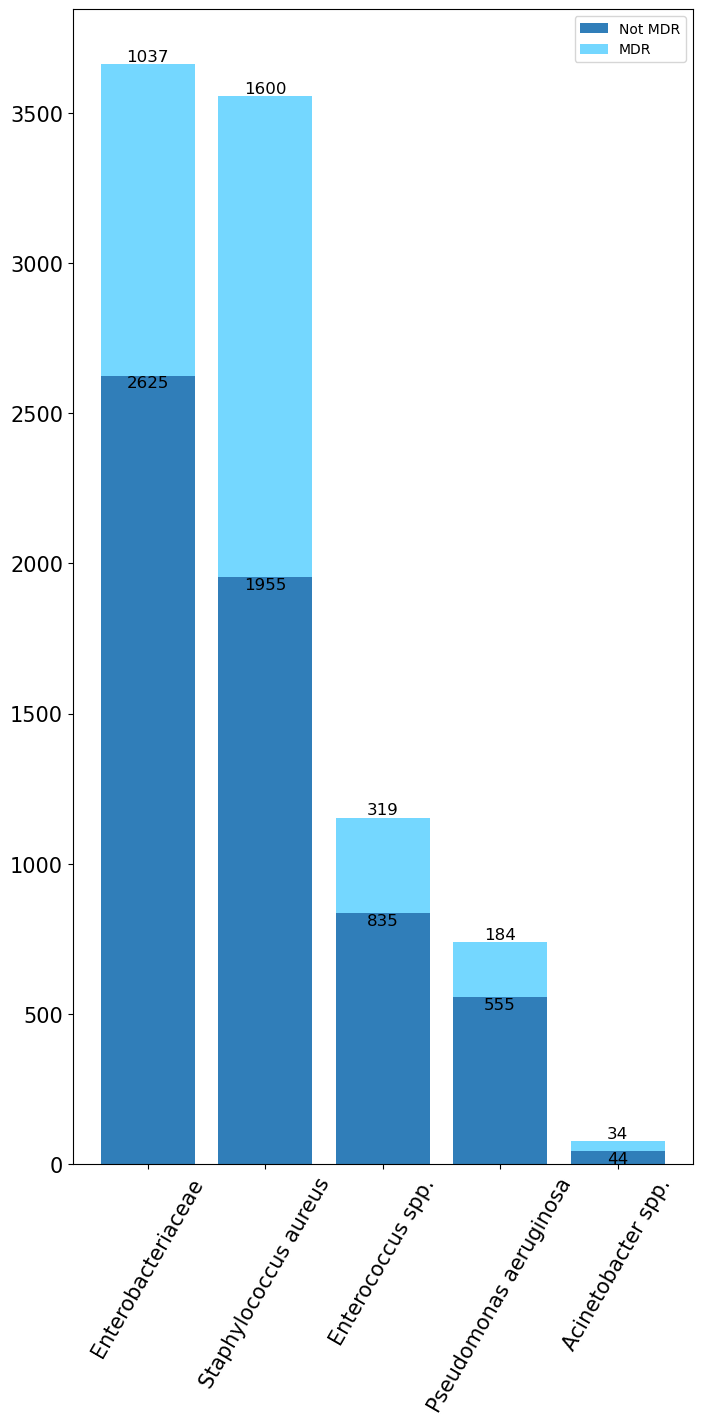

In [19]:
mdr_plot_cat = micro_sel[['org_name','MDR']]
mdr_plot_cat = pd.merge(mdr_plot_cat,org_name_sel.iloc[:,1:4],how = 'left', on = 'org_name')
mdr_plot_cat = mdr_plot_cat[~pd.isna(mdr_plot_cat.org_category)]
mdr_plot_cat_bar1 = pd.DataFrame(mdr_plot_cat[mdr_plot_cat['MDR']==1].groupby(['org_category','MDR']).count()['org_name']).reset_index().sort_values(by = 'org_name',ascending = False)
mdr_plot_cat_bar0 = pd.DataFrame(mdr_plot_cat[mdr_plot_cat['MDR']==0].groupby(['org_category','MDR']).count()['org_name']).reset_index().sort_values(by = 'org_name',ascending = False)
mdr_plot_cat_bar = pd.merge(mdr_plot_cat_bar1,mdr_plot_cat_bar0,how = 'right', on = 'org_category')
#with plt.style.context(['science','notebook','ieee','no-latex']):
plt.figure(figsize= (8,15))
plt.bar(mdr_plot_cat_bar['org_category'],mdr_plot_cat_bar['org_name_y'],color='#307eb9',label='Not MDR')
plt.bar(mdr_plot_cat_bar['org_category'],mdr_plot_cat_bar['org_name_x'],color='#74d7ff',bottom=mdr_plot_cat_bar['org_name_y'], label = 'MDR')
plt.tick_params(labelsize = 15)
for x1,x2, y1, y2 in zip(mdr_plot_cat_bar['org_category'], mdr_plot_cat_bar['org_category'], mdr_plot_cat_bar['org_name_y'], mdr_plot_cat_bar['org_name_x']):
    plt.text(x1 , y1, '%.0f' % y1, ha='center', va='top',fontsize = 12)
    plt.text(x2 , y1+y2, '%.0f' % y2, ha='center', va='bottom',fontsize = 12)
plt.xticks(rotation = 60)
plt.legend(loc=1)

In [20]:
final_cohort_pre_id = final_cohort_pre[['subject_id','hadm_id_icu', 'stay_id','icu_intime']].drop_duplicates()
final_cohort_pre_id['icustay_rank']= final_cohort_pre.groupby(['subject_id'])['icu_intime'].rank()
final_cohort_pre = pd.merge(final_cohort_pre,final_cohort_pre_id.drop(columns = ['icu_intime']),how = 'right', on = ['subject_id', 'hadm_id_icu', 'stay_id'])

final_cohort_pre['los_icu_exc'] = final_cohort_pre['los_icu'].apply(lambda x:1 if x < 1 else 0)

final_cohort_stage0 = final_cohort_pre#[final_cohort_pre['last']==1]

final_cohort_stage1 = final_cohort_stage0[final_cohort_stage0['los_icu_exc']==0]

final_cohort_stage2 = final_cohort_stage1[(final_cohort_stage1['previous_mdrpos_lessthan14d'] != 1)&final_cohort_stage1['previous_mdrneg_lessthan14d'] != 1]

final_cohort_stage3 = final_cohort_stage2[final_cohort_stage2['stay_chart_included'] == 1]

In [21]:
final_cohort_stage3[final_cohort_stage3['previous_mdrpos_lessthan90d']==1].stay_chart_included_mdr.value_counts()

0    613
1    248
Name: stay_chart_included_mdr, dtype: int64

In [22]:
final_cohort_stage3[final_cohort_stage3['previous_mdrneg_lessthan90d']==1].stay_chart_included_mdr.value_counts()

0    566
1    300
Name: stay_chart_included_mdr, dtype: int64

In [23]:
final_cohort_stage3[final_cohort_stage3['stay_chart_included_mdr']==1].stay_chart_included_mdr_pos_tot.value_counts()

1    2468
0    1314
Name: stay_chart_included_mdr_pos_tot, dtype: int64

In [24]:
final_cohort_stage3.stay_chart_included_mdr.value_counts()

0    43870
1     3782
Name: stay_chart_included_mdr, dtype: int64

In [25]:
final_cohort_stage3.rename(columns = {'hadm_id_icu':'hadm_id'},inplace = True)

/tmp/ipykernel_1667906/3762540335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cohort_stage3.rename(columns = {'hadm_id_icu':'hadm_id'},inplace = True)


In [26]:
final_cohort_stage3['los_hosp_beforeicu'] = \
(final_cohort_stage3['icu_intime'] - final_cohort_stage3['admittime']).dt.total_seconds()/(3600*24)

/tmp/ipykernel_1667906/3776292511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cohort_stage3['los_hosp_beforeicu'] = \


In [27]:
final_cohort_stage3.to_csv('final_cohort.csv', index = False)

In [28]:
test0 = final_cohort_pre[(final_cohort_pre['stay_chart_included'] == 1)]

test1 = test0

test2 = test1[test1['los_icu_exc']==0]

test3 = test2[(test2['previous_mdrpos_lessthan14d'] != 1)&test2['previous_mdrneg_lessthan14d'] != 1]

In [29]:
final_cohort_pre.stay_id.drop_duplicates().shape

(70153,)

In [30]:
test0.stay_id.drop_duplicates().shape

(59932,)

In [31]:
test1.stay_id.drop_duplicates().shape

(59932,)

In [32]:
test2.stay_id.drop_duplicates().shape

(48133,)

In [33]:
test3.stay_id.drop_duplicates().shape

(47652,)

In [34]:
test = pd.read_csv('final_cohort.csv')

In [35]:
from tableone import TableOne

In [36]:
test.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'admittime', 'dischtime',
       'los_hospital', 'admission_age', 'race', 'hospital_expire_flag',
       'hospstay_seq', 'first_hosp_stay', 'icu_intime', 'icu_outtime',
       'los_icu', 'icustay_seq', 'first_icu_stay', 'spec_type_desc_URINE',
       'spec_type_desc_BLOOD CULTURE', 'spec_type_desc_SWAB',
       'spec_type_desc_SPUTUM', 'spec_type_desc_TISSUE',
       'spec_type_desc_BRONCHOALVEOLAR LAVAGE', 'spec_type_desc_ABSCESS',
       'firsthospmdrcharttime', 'firsthospmdrstoretime', 'firsthospmdrorgname',
       'firsthospmdrRAB', 'last', 'previous_mdrpos_lessthan14d',
       'previous_mdrneg_lessthan14d', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d', 'stay_chart_included',
       'stay_chart_included_mdr', 'stay_chart_included_mdr_neg_tot',
       'stay_chart_included_mdr_pos_tot', 'icustay_rank', 'los_icu_exc',
       'los_hosp_beforeicu'],
      dtype='object')

In [37]:
columns_dev_ini = [
 'gender', 
       'los_hospital', 'admission_age',
       'hospital_expire_flag',  'los_icu','previous_mdrpos_lessthan14d',
       'previous_mdrneg_lessthan14d', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d',  'los_hosp_beforeicu',
       'stay_chart_included_mdr'
]

nonnormal_dev_ini = [
       'los_hospital', 'admission_age', 'los_icu', 'los_hosp_beforeicu'
]

category_dev_ini = [
 'gender', 
       'hospital_expire_flag', 'previous_mdrpos_lessthan14d',
       'previous_mdrneg_lessthan14d', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d',
       'stay_chart_included_mdr'
]
groupby_ini = ['stay_chart_included_mdr']
tableone_ = TableOne(test,
                      nonnormal=nonnormal_dev_ini,
                            categorical=category_dev_ini,
                            columns=columns_dev_ini,
                            groupby=groupby_ini,
                            label_suffix=True,
                            pval=True,
                            htest_name=True)

In [38]:
tableone_.to_csv('table_one.csv')